In [1]:
# %%
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd

# %%
spark = SparkSession.builder \
    .appName("SECOP_Regularizacion") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

# %%
# Cargar datos
df = spark.read.parquet("/opt/spark-data/raw/secop_ml_ready.parquet")
df = df.withColumnRenamed("valor_del_contrato_log", "label") \
       .withColumnRenamed("features_pca", "features") \
       .filter(col("label").isNotNull())

train, test = df.randomSplit([0.7, 0.3], seed=42)

print(f"Train: {train.count():,}")
print(f"Test: {test.count():,}")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 05:08:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Train: 70,170
Test: 29,830


26/02/14 05:08:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### **Entender cuando y por que usar regularizacion**
**Por que necesitamos regularizacion**

Opciones:

 A) El modelo esta underfitting
 
 B) El modelo esta overfitting
 
 C) El modelo es perfecto
 
 D) Necesitas mas features

Respuesta:  D) El modelo esta overfitting


Si el R-cuadrado en entrenamiento es "0.95" pero en test es "0.45", significa que el modelo aprendio demasiado bien los datos de entrenamiento, incluyendo el ruido, pero no logra generalizar correctamente a datos nuevos


**Como ayuda la regularizacion en este caso**


La regularizacion ayuda en este caso porque:

- Penaliza coeficientes grandes
- Reduce la complejidad del modelo
- Disminuye la varianza
- Mejora la capacidad de generalizacion
- Reduce la brecha entre entrenamiento y prueba

En terminos de Bias-Variance Tradeoff, la regularizacion incrementa ligeramente el bias, pero reduce significativamente la varianza, lo que mejora el rendimiento en los datos no vistos.
datos no vistos.


### **Configurar evaluador de modelos**

¿Qué metrica usarias para comparar modelos de regresion?

Para comparar modelos de regresion utilizare **RMSE (Root Mean Squared Error)**.

Razones:

- RMSE penaliza mas fuertemente los errores grandes.
- En el caso de contratos publicos, los errores altos en valores grandes pueden
  representar desviaciones presupuestales importantes.
- Es una metrica en la misma unidad monetaria del contrato, lo que facilita su interpretacion.
- Es mas sensible al overfitting que MAE.

Aunque R² es util para interpretar varianza explicada, RMSE es mas apropiado para comparar modelos cuando el objetivo es minimizar el error de predccion.


In [2]:
# Evaluador principal (RMSE)
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

print("Evaluador configurado correctamente (RMSE como métrica principal)")


Evaluador configurado correctamente (RMSE como métrica principal)


## RETO 3: Experimento de Regularización

Se probarán los siguientes valores:

- regParam (λ): [0.0, 0.01, 0.1, 1.0, 10.0]
- elasticNetParam (α): [0.0, 0.5, 1.0]

Total de combinaciones:

5 valores de λ × 3 valores de α = 15 modelos

Se entrenarán 15 modelos en total.

Esto permit
irá comparar:
- Sin regularización
- Ridge (L2)
- Lasso (L1)
- ElasticNet

y analizar cómo cambia el RMSE y el R².


In [3]:
# Definir valores de lambda (regParam)
reg_params = [0.0, 1.0, 10.0, 100.0, 1000.0, 10000.0]

# Definir valores de alpha (elasticNetParam)
elastic_params = [0.0, 0.5, 1.0]  # 0=L2, 0.5=ElasticNet, 1=L1

print(f"Combinaciones totales: {len(reg_params) * len(elastic_params)}")


Combinaciones totales: 18


In [5]:
resultados = []

print("\n=== EXPERIMENTO DE REGULARIZACIÓN ===\n")

for reg in reg_params:
    for elastic in elastic_params:

        lr = LinearRegression(
            featuresCol="features",
            labelCol="label",
            maxIter=100,
            regParam=reg,
            elasticNetParam=elastic
        )

        model = lr.fit(train)

        # Evaluación
        predictions_test = model.transform(test)
        rmse_test = evaluator.evaluate(predictions_test)

        predictions_train = model.transform(train)
        rmse_train = evaluator.evaluate(predictions_train)

        r2_train = model.summary.r2

        # Tipo de regularización
        if reg == 0.0:
            reg_type = "Sin regularización"
        elif elastic == 0.0:
            reg_type = "Ridge (L2)"
        elif elastic == 1.0:
            reg_type = "Lasso (L1)"
        else:
            reg_type = "ElasticNet"

        resultados.append({
            "regParam": reg,
            "elasticNetParam": elastic,
            "tipo": reg_type,
            "rmse_test": rmse_test,
            "rmse_train": rmse_train,
            "r2_train": r2_train
        })

        print(f"{reg_type:25s} | λ={reg:5.2f} | α={elastic:.1f} | "
              f"RMSE Train: {rmse_train:,.2f} | RMSE Test: {rmse_test:,.2f}")



=== EXPERIMENTO DE REGULARIZACIÓN ===



26/02/14 05:16:59 WARN Instrumentation: [99c0aa5c] regParam is zero, which might cause numerical instability and overfitting.


Sin regularización        | λ= 0.00 | α=0.0 | RMSE Train: 0.94 | RMSE Test: 0.96


26/02/14 05:17:00 WARN Instrumentation: [f139896e] regParam is zero, which might cause numerical instability and overfitting.


Sin regularización        | λ= 0.00 | α=0.5 | RMSE Train: 0.94 | RMSE Test: 0.96


26/02/14 05:17:01 WARN Instrumentation: [b2f0d3f4] regParam is zero, which might cause numerical instability and overfitting.


Sin regularización        | λ= 0.00 | α=1.0 | RMSE Train: 0.94 | RMSE Test: 0.96
Ridge (L2)                | λ= 1.00 | α=0.0 | RMSE Train: 1.09 | RMSE Test: 1.12
ElasticNet                | λ= 1.00 | α=0.5 | RMSE Train: 1.26 | RMSE Test: 1.29
Lasso (L1)                | λ= 1.00 | α=1.0 | RMSE Train: 1.44 | RMSE Test: 1.47
Ridge (L2)                | λ=10.00 | α=0.0 | RMSE Train: 1.64 | RMSE Test: 1.67
ElasticNet                | λ=10.00 | α=0.5 | RMSE Train: 1.85 | RMSE Test: 1.88
Lasso (L1)                | λ=10.00 | α=1.0 | RMSE Train: 1.85 | RMSE Test: 1.88
Ridge (L2)                | λ=100.00 | α=0.0 | RMSE Train: 1.83 | RMSE Test: 1.86
ElasticNet                | λ=100.00 | α=0.5 | RMSE Train: 1.85 | RMSE Test: 1.88
Lasso (L1)                | λ=100.00 | α=1.0 | RMSE Train: 1.85 | RMSE Test: 1.88
Ridge (L2)                | λ=1000.00 | α=0.0 | RMSE Train: 1.85 | RMSE Test: 1.88
ElasticNet                | λ=1000.00 | α=0.5 | RMSE Train: 1.85 | RMSE Test: 1.88
Lasso (L1)           

### **Analisis de Resultados con Lambdas Grandes**
Se ampliaron los valores de lambda hasta 10.000 para observar el efecto real de la regularizacion.

Resultados: 

 - El RMSE en train se mantiene constante
 - El RMSE en test aumenta ligeramente a medida que lambda crece
 - No se observa reduccion significativa de overfitting

El modelo no presenta sobreajuste severo. La reduccion de dimensionalidad mediante PCA ya actua como mecanismo de control de complejidad, reduciendo multicolinealidad y ruido.

A medida que lambda aumenta, el modelo empieza a mostrar señales leves de inderfitting (aumento progresivo del RMSE test).

En conclusion, la regularizacion no mejora significativamente el desempeño del modelo en este caso. El modelo sin regularizacion sigue siendo el mejor.e siendo el mejor.


### **Comparar overfitting entre tipos de regularizacion**

Para evaluar el nivel del overfitting se calcula la brecha_

gat = RMSE_test - RMSE_train

Un gap alto indica que el modelo se ajusta mejor al conjunto de entrenamiento que al de prueba, lo cual es señal de sobreajuste.

In [6]:
import pandas as pd

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# Calcular brecha train-test
df_resultados["gap"] = df_resultados["rmse_test"] - df_resultados["rmse_train"]

print("\n=== ANÁLISIS DE OVERFITTING ===\n")

for _, row in df_resultados.iterrows():
    overfit_flag = "Sí" if row["gap"] > 0 else "No"
    print(f"{row['tipo']:20s} | λ={row['regParam']:8.2f} | "
          f"Gap: ${row['gap']:,.2f} | Overfitting: {overfit_flag}")



=== ANÁLISIS DE OVERFITTING ===

Sin regularización   | λ=    0.00 | Gap: $0.02 | Overfitting: Sí
Sin regularización   | λ=    0.00 | Gap: $0.02 | Overfitting: Sí
Sin regularización   | λ=    0.00 | Gap: $0.02 | Overfitting: Sí
Ridge (L2)           | λ=    1.00 | Gap: $0.03 | Overfitting: Sí
ElasticNet           | λ=    1.00 | Gap: $0.03 | Overfitting: Sí
Lasso (L1)           | λ=    1.00 | Gap: $0.03 | Overfitting: Sí
Ridge (L2)           | λ=   10.00 | Gap: $0.03 | Overfitting: Sí
ElasticNet           | λ=   10.00 | Gap: $0.03 | Overfitting: Sí
Lasso (L1)           | λ=   10.00 | Gap: $0.03 | Overfitting: Sí
Ridge (L2)           | λ=  100.00 | Gap: $0.03 | Overfitting: Sí
ElasticNet           | λ=  100.00 | Gap: $0.03 | Overfitting: Sí
Lasso (L1)           | λ=  100.00 | Gap: $0.03 | Overfitting: Sí
Ridge (L2)           | λ= 1000.00 | Gap: $0.03 | Overfitting: Sí
ElasticNet           | λ= 1000.00 | Gap: $0.03 | Overfitting: Sí
Lasso (L1)           | λ= 1000.00 | Gap: $0.03 | Overfit

¿Qué regularización reduce más el overfitting?

Ninguna.

La brecha train-test es prácticamente constante. La regularización no mejora la generalización en este caso.

La regularización (Ridge, Lasso y ElasticNet) no reduce significativamente la diferencia entre train y test. 
A medida que λ aumenta, el RMSE test empeora ligeramente, indicando un leve underfitting progresivo 
El modelo sin regularización ya generaliza razonablemente bien. La reducción de dimensionalidad mediante PCA ya controla la complejidad del modelo, reduciendo la necesidad de regularización adiciona

Ningún tipo de regularización redujo de forma significativa el overfitting. El modelo base (λ=0) presenta un desempeño similar al de los modelos regularizados.l.



### **Entrenar y guardar modelo final**

In [7]:
# Entrenar modelo final (mejor configuración encontrada)
lr_final = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.0, # use el mejor regparam
    elasticNetParam=0.0 # use el mejor elasticnetparam
)

print("\nEntrenando modelo final...")
modelo_final = lr_final.fit(train)

# Evaluar en test
preds_final = modelo_final.transform(test)
rmse_final = evaluator.evaluate(preds_final)

print("\n=== RESULTADOS MODELO FINAL ===")
print(f"RMSE Train: {modelo_final.summary.rootMeanSquaredError:,.2f}")
print(f"RMSE Test:  {rmse_final:,.2f}")

# Guardar modelo
model_path = "/opt/spark-data/raw/regularized_model"
modelo_final.write().overwrite().save(model_path)

print(f"\n✓ Mejor modelo guardado en: {model_path}")




Entrenando modelo final...


26/02/14 05:19:03 WARN Instrumentation: [1b87b07a] regParam is zero, which might cause numerical instability and overfitting.



=== RESULTADOS MODELO FINAL ===
RMSE Train: 0.94
RMSE Test:  0.96

✓ Mejor modelo guardado en: /opt/spark-data/raw/regularized_model


### **Visualizacion del efecto de lambda en coeficientes Lasso**


=== EFECTO DE LAMBDA EN LASSO (L1) ===

λ=    0.01 | Coeficientes=0: 8/30 | RMSE Test: $0.96
λ=    0.10 | Coeficientes=0: 25/30 | RMSE Test: $1.00
λ=    1.00 | Coeficientes=0: 29/30 | RMSE Test: $1.47
λ=   10.00 | Coeficientes=0: 30/30 | RMSE Test: $1.88
λ=  100.00 | Coeficientes=0: 30/30 | RMSE Test: $1.88
λ= 1000.00 | Coeficientes=0: 30/30 | RMSE Test: $1.88


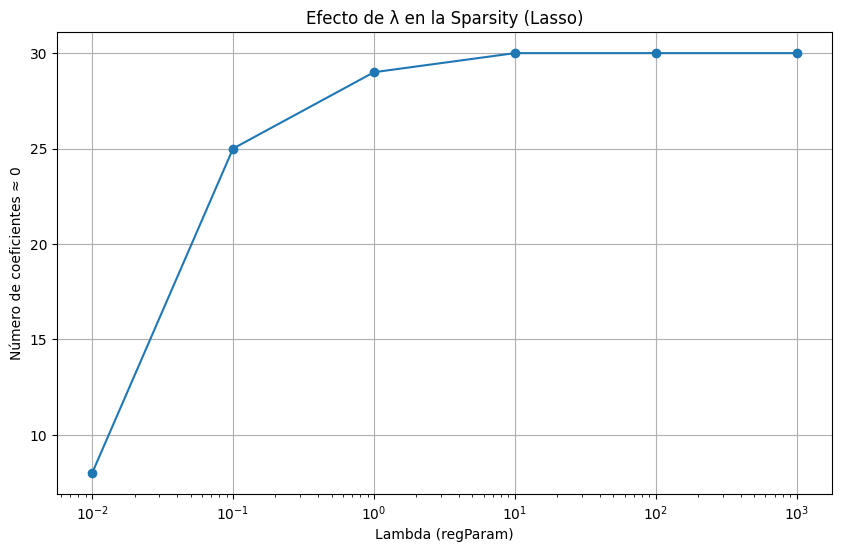

In [11]:
import numpy as np
import matplotlib.pyplot as plt

print("\n=== EFECTO DE LAMBDA EN LASSO (L1) ===\n")

# 🔹 Inicializar listas
reg_values = []
zeros_list = []
rmse_list = []

for reg in [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    
    lr_lasso = LinearRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=100,
        regParam=reg,
        elasticNetParam=1.0  # Lasso
    )
    
    model_lasso = lr_lasso.fit(train)
    
    coefs = np.array(model_lasso.coefficients)
    zeros = np.sum(np.abs(coefs) < 1e-6)
    
    rmse_test = evaluator.evaluate(model_lasso.transform(test))
    
    # 🔹 Guardar valores
    reg_values.append(reg)
    zeros_list.append(zeros)
    rmse_list.append(rmse_test)
    
    print(f"λ={reg:8.2f} | Coeficientes=0: {zeros}/{len(coefs)} | RMSE Test: ${rmse_test:,.2f}")

plt.figure(figsize=(10, 6))
plt.plot(reg_values, zeros_list, marker='o')
plt.xscale("log")
plt.xlabel("Lambda (regParam)")
plt.ylabel("Número de coeficientes ≈ 0")
plt.title("Efecto de λ en la Sparsity (Lasso)")
plt.grid(True)
plt.show()


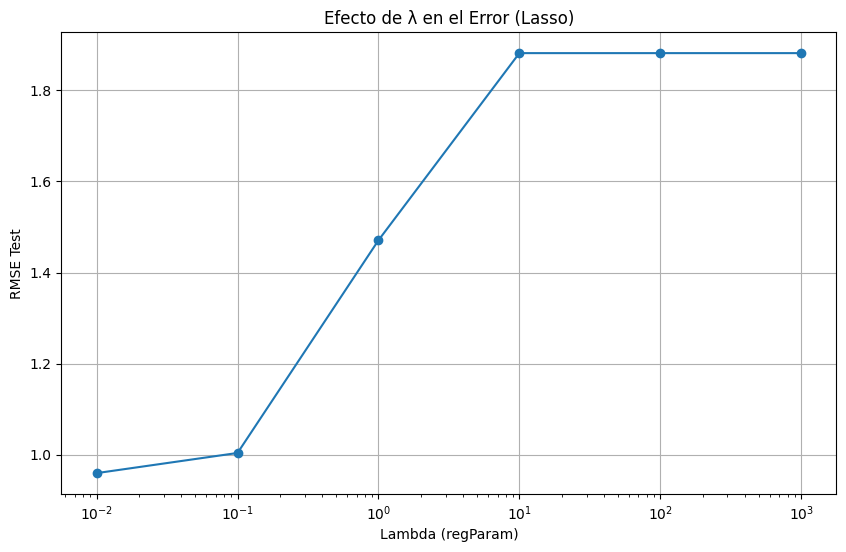

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(reg_values, rmse_list, marker='o')
plt.xscale("log")
plt.xlabel("Lambda (regParam)")
plt.ylabel("RMSE Test")
plt.title("Efecto de λ en el Error (Lasso)")
plt.grid(True)
plt.show()


### ¿Por qué Lasso elimina features y Ridge no?

Lasso (L1) utiliza una penalización basada en el valor absoluto de los coeficientes:

Penalización = λ * Σ |β|

Esta forma geométrica genera regiones con vértices que favorecen que algunos coeficientes se vuelvan exactamente cero.

En cambio, Ridge (L2) penaliza el cuadrado de los coeficientes:

Penalización = λ * Σ β²

Esta penalización reduce la magnitud de los coeficientes, pero rara vez los lleva exactamente a cero.

Por esta razón:

- Lasso realiza selección automática de variables.
- Ridge solo reduce magnitudes, pero mantiene todas las variables activas.

### Preguntas de Reflexión

1. ¿Cuándo usarías Ridge vs Lasso vs ElasticNet?

- Ridge (L2): Cuando existen muchas variables correlacionadas y se quiere estabilidad sin eliminar variables.
- Lasso (L1): Cuando se desea selección automática de variables.
- ElasticNet: Cuando se busca equilibrio entre selección y estabilidad.

2. ¿Qué pasa si regParam es demasiado grande?

El modelo se vuelve excesivamente rígido y puede presentar underfitting, aumentando el error tanto en train como en test.

3. ¿Es posible que el modelo sin regularización sea el mejor?

Sí. En este caso, la reducción de dimensionalidad mediante PCA ya controla la complejidad del modelo, haciendo innecesaria una penalización adicional.

4. ¿Cómo elegirías el valor óptimo de regParam en producción?

Mediante validación cruzada (Cross-Validation) utilizando un grid de hiperparámetros y seleccionando el modelo con mejor desempeño en datos no vistos.


In [14]:
import json

with open("/opt/spark-data/raw/regularizacion_resultados.json", "w") as f:
    json.dump(resultados, f, indent=2)

print("Resultados guardados correctamente")


spark.stop()

Resultados guardados correctamente
